## (a) Reading and manipulating the dataset:

In [1]:
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from skimage import feature
from skimage import filters
from skimage import color
import numpy as np
import imageio
%matplotlib inline
plt.rcParams.update({'image.interpolation': None})
plt.rcParams.update({'font.size': 15})

### (a-i) Displaying an example image:

Text(0.5, 1.0, 'The histogram of the blue channel of easy1 image')

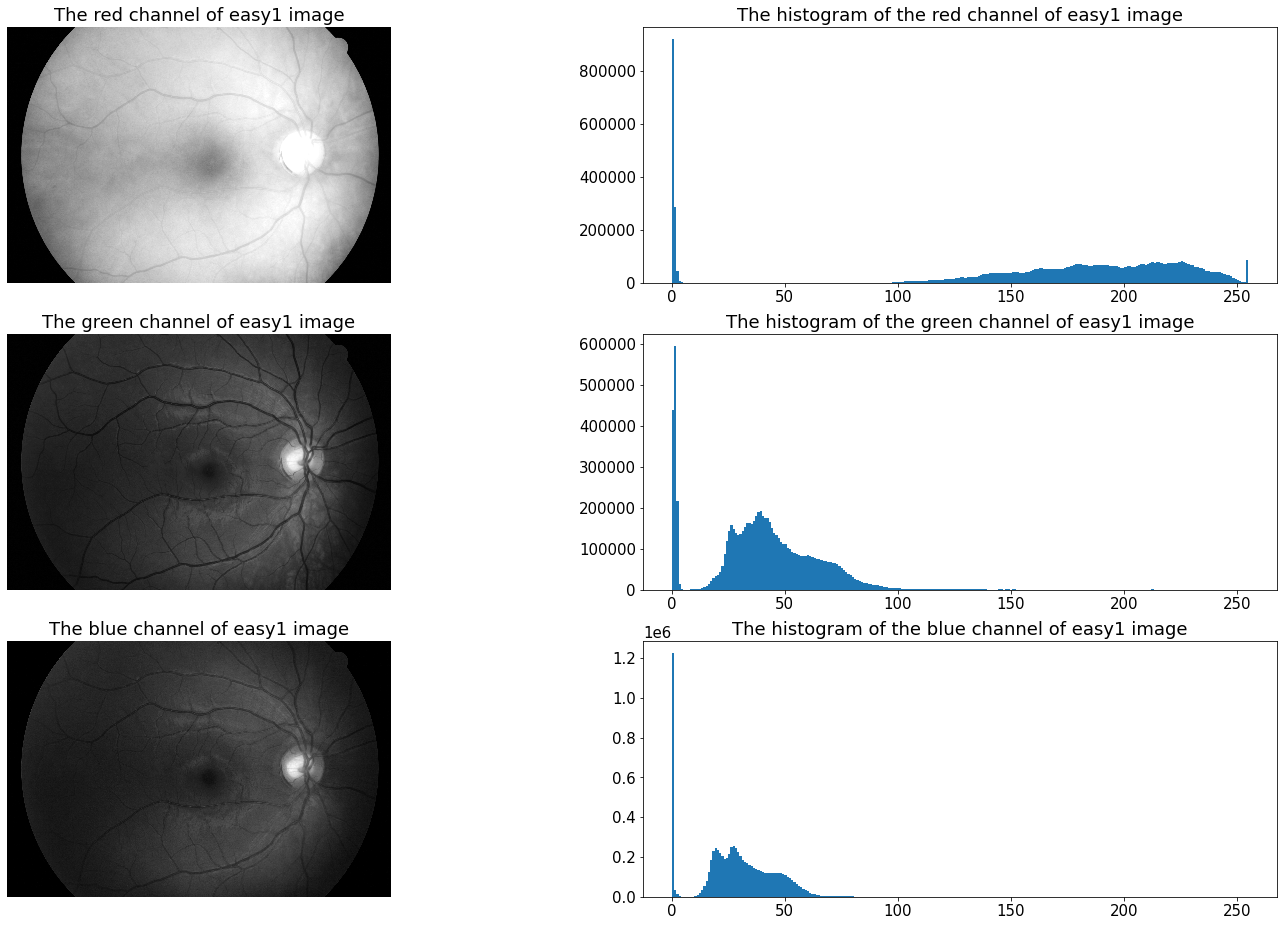

In [2]:
I = np.asarray(imageio.imread('easy1.jpg'))
Ir = I[:,:,0]
Ig = I[:,:,1]
Ib = I[:,:,2]

plt.figure(figsize=(25,16))

plt.subplot(3,2,1)
plt.imshow(Ir,cmap="gray")
plt.axis('off')
plt.title('The red channel of easy1 image')

plt.subplot(3,2,2)
plt.hist(Ir.flatten(),bins=256,range=[0,255])
plt.title('The histogram of the red channel of easy1 image')

plt.subplot(3,2,3)
plt.imshow(Ig,cmap="gray")
plt.axis('off')
plt.title('The green channel of easy1 image')

plt.subplot(3,2,4)
plt.hist(Ig.flatten(),bins=256,range=[0,255])
plt.title('The histogram of the green channel of easy1 image')

plt.subplot(3,2,5)
plt.imshow(Ib,cmap="gray")
plt.axis('off')
plt.title('The blue channel of easy1 image')

plt.subplot(3,2,6)
plt.hist(Ib.flatten(),bins=256,range=[0,255])
plt.title('The histogram of the blue channel of easy1 image')

### (a-ii) Displaying an example ground truth image:

Text(0.5, 1.0, 'The manually annotated (ground truth) mask of the vessels in easy1 image')

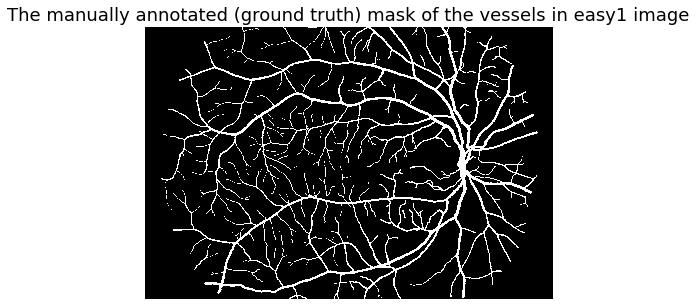

In [3]:
I_gt = np.asarray(imageio.imread('easy1_gt.tif'))

plt.figure(figsize=(8,5))

plt.imshow(I_gt,cmap="gray")
plt.axis('off')
plt.title('The manually annotated (ground truth) mask of the vessels in easy1 image')

### (a-iii) Coding ground truth vessels red:

Text(0.5, 1.0, 'The green channel of the easy1 image with ground truth vessels coded red')

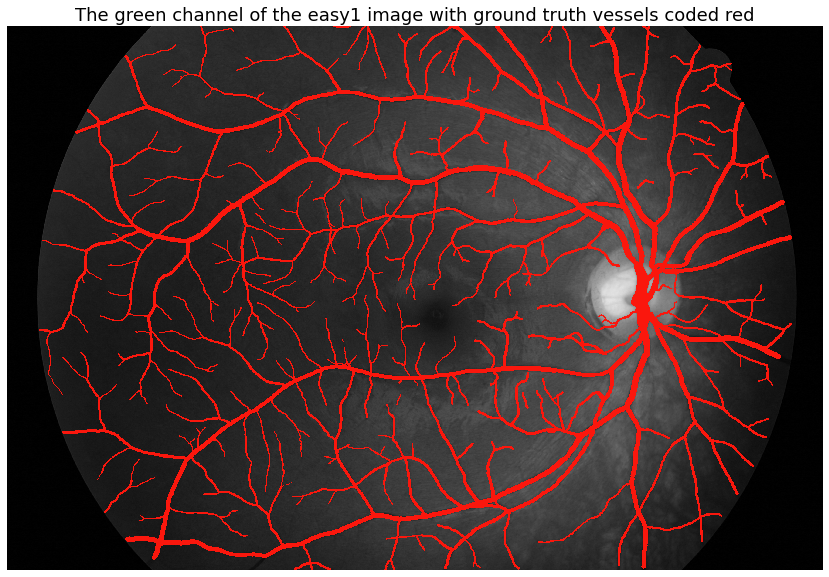

In [4]:
I = np.asarray(imageio.imread('easy1.jpg'))
Ir = I[:,:,0]
Ig = I[:,:,1]
Ib = I[:,:,2]
Ir = np.where(I_gt==255, 250, Ig)
Ig = np.where(I_gt==255, 23, Ig)
Ib = np.where(I_gt==255, 13, Ig)
I_blood = np.dstack((Ir,Ig,Ib))

plt.figure(figsize=(15,10))
plt.imshow(I_blood)
plt.axis('off')
plt.title('The green channel of the easy1 image with ground truth vessels coded red')

By comparing the green channel of the easy image with the obtained image from this part, it can figure out that segmenting the blood vessels in this kind of image is so difficult. The background of vessels has different intensities depending on how far from the optic disk. For example, near the optic disk, this image has higher intensity. Thus distinguishing between vessels and background is possible but near the eye borders, distinguishing becomes more difficult because the intensity of vessels and background become more similar. In addition, the background of the vessels is not simple, there is some shadow of blood vessels in the background of the vessels. Moreover, vessels have different shapes and sizes and uneven illumination. The size of fundus images and their contrast and their illumination is different, thus finding a single approach to segmenting blood vessels and working accurately for all fundus images is so difficult.

### (a-iv) Coding ground truth optic disk yellow:

In [5]:
def make_circle_mask(c,im_dims,r):

    cx = c[0]
    cy = c[1]
    ix = im_dims[0]
    iy = im_dims[1]
    x,y = np.meshgrid(np.arange(-(cx),(ix-cx),1),np.arange(-(cy),(iy-cy),1))
    c_mask = (x**2+y**2)<=r**2
    
    return c_mask

Text(0.5, 1.0, 'The green channel of the easy1 image with ground truth optic disk coded yellow')

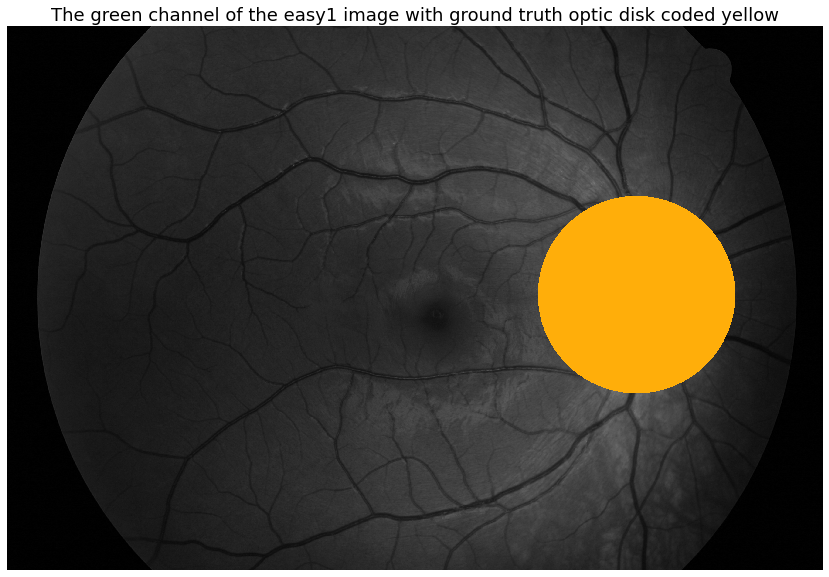

In [6]:
x=2703
y=1153
r=424
c=[x,y]
im_dims=np.flip(Ig.shape)
I_masked=make_circle_mask(c,im_dims,r)

I = np.asarray(imageio.imread('easy1.jpg'))
Ir = I[:,:,0]
Ig = I[:,:,1]
Ib = I[:,:,2]

Ir = np.where(I_masked==True, 255, Ig)
Ig = np.where(I_masked==True, 174, Ig)
Ib = np.where(I_masked==True, 10, Ig)

I_disk = np.dstack((Ir,Ig,Ib))

plt.figure(figsize=(15,10))
plt.imshow(I_disk)
plt.axis('off')
plt.title('The green channel of the easy1 image with ground truth optic disk coded yellow')


Based on the original image, segmenting the optical disk is difficult. The shape of the optical disk is a circle and it has pixels that have higher intensity but they are surrounded by pixels with less intensity. Thus, detecting this disk from the rest of the image is not easy. The intensity of pixels in this optical disk is not constant and the intensity has a sudden change in this area because of passing the blood vessels. Also, optical disks vary in terms of appearance, size, location, and intensity in different eyes. In addition, the location of this region varies in the different fundus images. The optical disk causes uneven illumination in its neighbor areas and make the segmentation difficult.

## (b) Defining the metrics:

In [7]:
def seg_metrics(I_seg,I_gt):
    
    tp = np.where((I_seg==1)&(I_gt==1),1,0)
    TP = tp.sum()
    tn = np.where((I_seg==0)&(I_gt==0),1,0)
    TN = tn.sum()
    fp = np.where((I_seg==1)&(I_gt==0),1,0)
    FP = fp.sum()
    fn = np.where((I_seg==0)&(I_gt==1),1,0)
    FN = fn.sum()
    
    import math
    e=math.exp(-50)

    TPR = TP/(TP+FN+e) 
    TNR = TN/(TN+FP+e)
    FPR = FP/(TN+FP+e)
    FNR = FN/(TP+FN+e)
    
    return TPR,TNR,FPR,FNR

In [8]:
I_seg=np.zeros((10,10))
I_seg[0:3,:]=1
I_gt=np.zeros((10,10))
I_gt[2:,4:]=1

TPR,TNR,FPR,FNR=seg_metrics(I_seg,I_gt)

print("TPR=",TPR)
print("TNR=",TNR)
print("FPR=",FPR)
print("FNR=",FNR)

TPR= 0.125
TNR= 0.5384615384615384
FPR= 0.46153846153846156
FNR= 0.875


The input of the seg_metrics function is the obtained segmentation mask and the ground truth mask. By comparing the intensity values of these two masks, four different metrics can be defined. True positive is the number of pixels that have an intensity value of 1 in two input images. Thus, by using "np.where" function and defining two conditions, this goal can be achieved. Two conditions are the intersection of pixels that have intensity 1 in both I_seg and I_gt. For TN, these two conditions are pixels that have intensity 0 in both input images. For FP, the pixels that have intensity 1 in I_seg and 0 in I_gt and for FN, the pixels that have intensity 0 in I_seg and intensity 1 in I_gt are considered. These two conditions are defined by "&" logic in "np.where" to consider the case in which these two conditions happen together. Then define the four metrics of TPR, TNR, FPR and FNR based on their definition. To avoid any "Nan" error in computing these metrics because of the equality of denominator to zero, the small value is added to all denominators of metrics.

## (c) Segmenting the optic disk:

### (c-i) Optic disk segmentation:

In [917]:
def segment_optic_disk(I):
    
    # Convert RGB image to HSV
    I_hsv = color.rgb2hsv(I)
    H = I_hsv[:,:,0]
    S = I_hsv[:,:,1]
    V = I_hsv[:,:,2]
    # Histogram equalization of V channel
    V_histeq = exposure.equalize_hist(V)
    # Generate the HSV image based on H, S and histogram equalized V 
    I_hsv_vhisteq = np.dstack((H,S,V_histeq))
    # Convert HSV to RGB image
    I_hsv_vhisteq_rgb=color.hsv2rgb(I_hsv_vhisteq)
    # Extract the green channel of RGB image
    Ib = I_hsv_vhisteq_rgb[:,:,1]
    # Define the average filter of size 13x13
    average_kernel = np.ones((13,13))/169
    # Smoothing image with avaraging image
    Ig_smoothed = ndimage.convolve(Ib,average_kernel, mode="nearest")
    
    I2=Ig_smoothed
    
    # Sobel masks
    sobel_horiz = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    sobel_vert = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    #filter image with sobel mask
    gx = ndimage.convolve(I2.astype(float), sobel_horiz, mode='nearest')
    gy = ndimage.convolve(I2.astype(float), sobel_vert, mode='nearest')
    # Compute the gradient magnitude image
    g = abs(gx)+abs(gy)
    
    # Define threshold for gradient image
    thresh=np.percentile(g,99.8)
    # Threshold gradient image
    g_thresh = g >= thresh
    # Compute the Otsu threshold using non-zero pixels of masked image
    T2_otsu=filters.threshold_otsu(I2[g_thresh],nbins=256)
    # Thresholding the image with the threshold value obtained from Otsu image
    I2s_ostu = I2.astype(float)>T2_otsu
    
    return T2_otsu, I2s_ostu

For segmentation of optic disk in fundus images, define the function of segment_optic_disk. The input of this function is just the original image. Segmenting the optical disk in fundus images is difficult because of various sizes, contrast and intensity value. Thus, finding a unique approach for thresholding the image and extracting this area from the other part of an image is difficult. The proposed method for this goal is as follows:
Firstly, converting the RGB image to an HSV image and then extracting each channel of H, S and V. Then, the histogram equalization is applied to channel V. Histogram equalized of channel V produces an excellent image. It helps the color retained correctly and the overall image seems sharper. The next step is converting back the HSV channels to RGB and extracting the green channels of this image. The green channel is smoothed with an average filter size of 13x13. Filtering is reduced the amount of intensity variation between neighboring pixels. It is so helpful for removing noise and enhancing image features. Most fundus images are noisy and the average filtering helps to reduce the effect of noise and contributes to extracting the image feature more correctly. The mode of convolving the green channel with the average kernel is chosen "nearest". Then, computing the magnitude of the gradient image with the help of Sobels masks. For choosing the threshold value of gradient image, it has tried to test different images to find the best trade-off for this part. The threshold is chosen at the 99 percentile and the gradient magnitude image is the threshold with this value. The original image (the green channel of the image) is masked using the thresholded gradient image. The obtained image from this stage is used in the Otsu algorithm. The non-zero pixels from the masked image are used to compute the Otsu threshold. Then, thresholding the original image with the obtained threshold value computed from the Otsu method. In all stages of the proposed algorithm, the float type of image is used. The logic of this image is using edges to improve the global thresholding as the optical disk has a higher intensity than other parts of an image.

### (c-ii) Optic disk segmentation performance:

In [932]:
I_easy = np.asarray(imageio.imread('easy1.jpg'))
I_medium = np.asarray(imageio.imread('medium1.jpg'))
I_hard = np.asarray(imageio.imread('hard1.jpg'))

Ig_easy = I_easy[:,:,1]
Ig_medium = I_medium[:,:,1]
Ig_hard = I_hard[:,:,1]

T_easy,I_easy_disk = segment_optic_disk(I_easy)
T_medium,I_medium_disk = segment_optic_disk(I_medium)
T_hard,I_hard_disk = segment_optic_disk(I_hard)
                                 
Ir_easy = np.where(I_easy_disk==True, 255, Ig_easy)
Ig_easy = np.where(I_easy_disk==True, 174, Ig_easy)
Ib_easy = np.where(I_easy_disk==True, 10, Ig_easy)
I_easy_disk2 = np.dstack((Ir_easy,Ig_easy,Ib_easy))

Ir_medium = np.where(I_medium_disk==True, 255, Ig_medium)
Ig_medium = np.where(I_medium_disk==True, 174, Ig_medium)
Ib_medium = np.where(I_medium_disk==True, 10, Ig_medium)
I_medium_disk2 = np.dstack((Ir_medium,Ig_medium,Ib_medium))

Ir_hard = np.where(I_hard_disk==True, 255, Ig_hard)
Ig_hard = np.where(I_hard_disk==True, 174, Ig_hard)
Ib_hard = np.where(I_hard_disk==True, 10, Ig_hard)
I_hard_disk2 = np.dstack((Ir_hard,Ig_hard,Ib_hard))


#### Easy1 image

In [933]:
x=2703
y=1153
c=[x,y]
r=424
im_dims=np.flip(Ig.shape)

I_masked_easy=make_circle_mask(c,im_dims,r)

TPR of easy1 image= 0.16892938787002
TNR of easy1 image= 0.9997441150060015
FPR of easy1 image= 0.00025588499399851274
FNR of easy1 image= 0.83107061212998


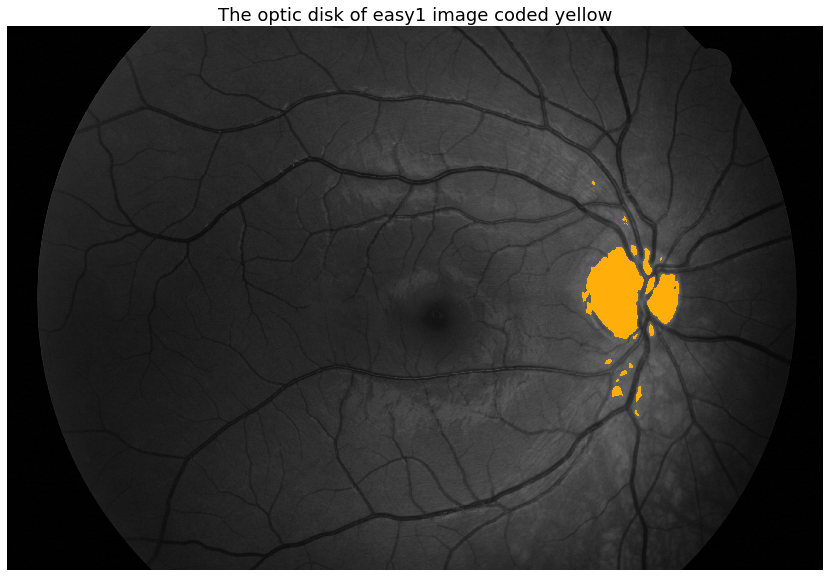

In [934]:
plt.figure(figsize=(15,10))
plt.imshow(I_easy_disk2,cmap='gray')
plt.axis('off')
plt.title('The optic disk of easy1 image coded yellow')

TPR,TNR,FPR,FNR=seg_metrics(I_easy_disk,I_masked_easy)

print("TPR of easy1 image=",TPR)
print("TNR of easy1 image=",TNR)
print("FPR of easy1 image=",FPR)
print("FNR of easy1 image=",FNR)

#### Medium1 image

In [935]:
x=2748
y=1155
c=[x,y]
r=402
im_dims=np.flip(Ig.shape)
I_masked_medium=make_circle_mask(c,im_dims,r)

TPR  of medium1 image= 0.16612529916381866
TNR  of medium1 image= 0.9980789767324213
FPR  of medium1 image= 0.0019210232675786524
FNR  of medium1 image= 0.8338747008361813


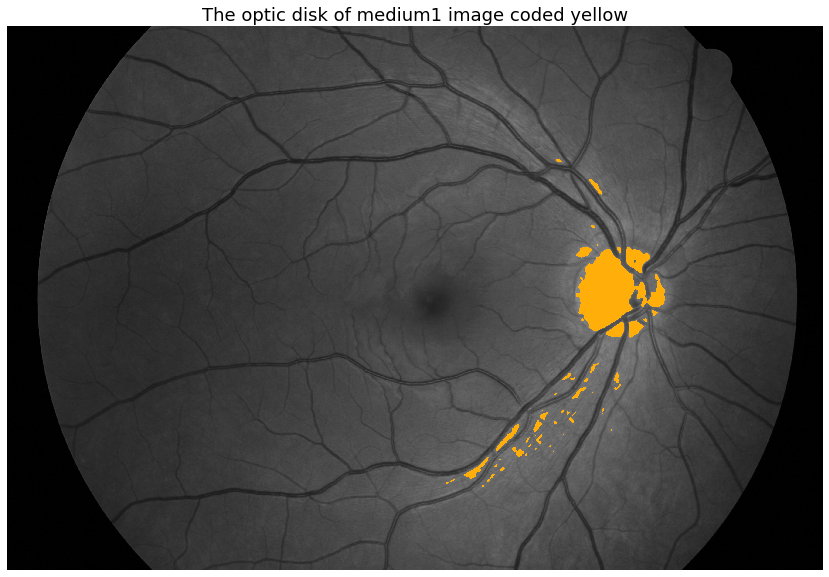

In [936]:
plt.figure(figsize=(15,10))
plt.imshow(I_medium_disk2,cmap='gray')
plt.axis('off')
plt.title('The optic disk of medium1 image coded yellow')

TPR,TNR,FPR,FNR = seg_metrics(I_medium_disk,I_masked_medium)

print("TPR  of medium1 image=",TPR)
print("TNR  of medium1 image=",TNR)
print("FPR  of medium1 image=",FPR)
print("FNR  of medium1 image=",FNR)

#### Hard1 image

In [937]:
x=2695
y=1144
c=[x,y]
r=364
im_dims=np.flip(Ig.shape)
I_masked_hard=make_circle_mask(c,im_dims,r)

TPR  of hard1 image= 0.5898663244881138
TNR  of hard1 image= 0.779630609998189
FPR  of hard1 image= 0.220369390001811
FNR  of hard1 image= 0.4101336755118861


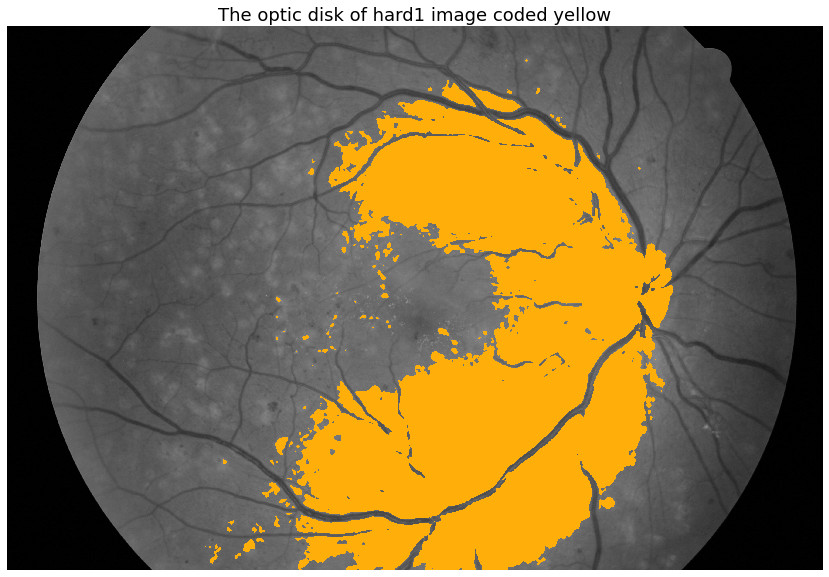

In [938]:
plt.figure(figsize=(15,10))
plt.imshow(I_hard_disk2,cmap='gray')
plt.axis('off')
plt.title('The optic disk of hard1 image coded yellow')

TPR,TNR,FPR,FNR = seg_metrics(I_hard_disk,I_masked_hard)

print("TPR  of hard1 image=",TPR)
print("TNR  of hard1 image=",TNR)
print("FPR  of hard1 image=",FPR)
print("FNR  of hard1 image=",FNR)

### (c-iii) Summary of optic disk segmentation performance:

The optic disk of three images of easy1, medium1 and hard1 are segmented with the proposed method and its performance is reported based on the four metrics. The proposed method has tried to segment the optical disk correctly. It provides a relatively good result in easy and medium segmentation. The circle related to the optic disk is segmented but by increasing the difficulty of images, some other pixels that are related to this threshold are also considered in this segmentation. As is shown, in the hard image, the neighbor areas around the optic disk are also considered in this segmentation. This comparison shows that this algorithm has good performance if an image has high contrast. It means the difference between light and dark is huge and there is a good separation between the high and dark intensity in its histogram. The image has bright highlights and dark shadows, bold colors and shows texture in the subject. The proposed method has tried to increase these features in images. Also, these methods help the image provide the deep valleys to improve the thresholding, thus it has a good performance in noisy images. Because noise omits the valleys of a histogram and this method can reduce the effect of noise and it has tried to provide the separation valley in the image histogram. However, this has not had a good performance in bright images or images that have low contrast. It means the images that there is not an extreme difference between the darkest and the brightest areas, which causes finding the threshold difficult. This algorithm shows that it has a higher TPR rate, around 0.99 for the easy and medium images which are near one and 0.77 for the hard image. It means that the TP is high and the FN is low. It also has good FPR for easy and medium images, which is close to zero.

## (d) Segmenting the blood vessels:

### (d-i) Vessel segmentation:

In [939]:
def vessel_segmentation(I):
    
    # Scale the input image in the range of [0,255]
    I = I-np.min(I)
    I = (I/np.max(I))*255
    
    # Extract the green channel
    Ig = I[:,:,1]
    
    # Define average filter of size 13x13
    average_kernel = np.ones((13,13))/169
    # Smmothing image with the averaging filter
    Ig_smoothed = ndimage.convolve(Ig,average_kernel, mode="nearest")
    
    # Sobel masks
    sobel_horiz = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    sobel_vert = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    # Filter image with sobel mask
    gx = ndimage.convolve(Ig_smoothed.astype(float), sobel_horiz, mode='nearest')
    gy = ndimage.convolve(Ig_smoothed.astype(float), sobel_vert, mode='nearest')
    # Compute the gradient magnitude of image
    M = abs(gx)+abs(gy)
    # Compute the gradient angle of image in degree
    alpha = np.rad2deg(np.arctan(gy/(gx+0.00000001)))
    
    # Define a threshold for the magnitude gradient of image
    Tm = 0.11*np.max(M)
    # Define a band acceptable direction of the gradient angle of image
    Ta = 45
    # Compute horizontally oriented pixels
    gh = np.where((M > Tm)&((alpha < Ta)&(alpha > -Ta)), 1, 0)
    # Compute vertically oriented pixels
    A = 90
    gv = np.where((M > Tm)&((np.abs(alpha) < A+Ta)&(np.abs(alpha) > A-Ta)), 1 , 0)
    # Specify the length for filling gap between pixels
    L = 40 
    
    # Link horizontal edges
    gh_conn = gh
    row_number, column_number = gh.shape
    for i in range(row_number):
        counter = 0
        edge_begin = 0
        for j in range(column_number):
            if (gh[i,j] == 1) and (counter == 0):
                edge_begin = 1
            elif (gh[i,j] == 1) & (counter > L):
                counter = 0
            elif (gh[i,j] == 0) & (edge_begin == 1):
                counter += 1
            elif (gh[i,j] == 1) & (counter <= L):
                gh_conn[i,j-counter:j] = 1
                edge_begin = 0
                counter = 0
                
    # Link vertical edges
    gv_T = gv.T
    gv_conn = gv.T
    row_number, column_number = gv_T.shape
    for i in range(row_number):
        counter = 0
        edge_begin = 0
        for j in range(column_number):
            if (gv_T[i,j] == 1) and (counter == 0):
                edge_begin = 1
            elif (gv_T[i,j] == 1) & (counter > L):
                counter = 0
            elif (gv_T[i,j] == 0) & (edge_begin == 1):
                counter += 1
            elif (gv_T[i,j] == 1) & (counter <= L):
                gv_conn[i,j-counter:j] = 1
                edge_begin = 0
                counter = 0
    gv_conn = gv_conn.T 
    
    # Consider both vertical and horizontal edges in an image
    g_conn = gh_conn + gv_conn   
    # Define the obtained image as a mask with intensity 1
    g_conn = g_conn>0.5
    
    return g_conn

For segmenting the blood vessels of the fundus image, the vessel_segmentation function is defined. The input of this function is the original image. Firstly, scale the input image in the range of [0,255], then extract the green channel. In the next step, as this kind of image is noisy, define the average kernel of size 13x13 to smooth the green channel. The mode of convolution is chosen "nearest". Then, compute the angle and magnitude of the gradient image based on the Sobel masks. The next stage is computing the horizontally and vertically oriented pixels. For this purpose, some parameters should define to threshold the gradient magnitude (Tm) and limits the acceptable gradient angle. Then compute the gh and gv. For computing the gv, A should be considered at 90 degrees to detect the vertically oriented pixels. Next, these edges pixels should be linked together, thus filling the gaps between pixels that do not exceed a specific length of L. Then, consider both horizontal and vertical oriented linked edges. In the end, consider the threshold of 0.5 on the obtained image to set the intensity of edges as 1 and the background as 0. The logic of this approach is based on edge linking using local processing. It leads to detecting edges pixels and then linking them together to segment the blood vessels.

### (d-ii) Vessel segmentation performance:

In [940]:
I_easy = np.asarray(imageio.imread('easy1.jpg'))
I_medium = np.asarray(imageio.imread('medium1.jpg'))
I_hard = np.asarray(imageio.imread('hard1.jpg'))

I_easy_vessels = vessel_segmentation(I_easy)
I_medium_vessels = vessel_segmentation(I_medium)
I_hard_vessels = vessel_segmentation(I_hard)

In [941]:
Ig_easy = I_easy[:,:,1]
Ig_medium = I_medium[:,:,1]
Ig_hard = I_hard[:,:,1]

Ir_easy = np.where(I_easy_vessels==True, 255, Ig_easy)
Ig_easy = np.where(I_easy_vessels==True, 0, Ig_easy)
Ib_easy = np.where(I_easy_vessels==True, 0, Ig_easy)
I_easy_vessels2 = np.dstack((Ir_easy,Ig_easy,Ib_easy))

Ir_medium = np.where(I_medium_vessels==True, 255, Ig_medium)
Ig_medium = np.where(I_medium_vessels==True, 0, Ig_medium)
Ib_medium = np.where(I_medium_vessels==True, 0, Ig_medium)
I_medium_vessels2 = np.dstack((Ir_medium,Ig_medium,Ib_medium))

Ir_hard = np.where(I_hard_vessels==True, 255, Ig_hard)
Ig_hard = np.where(I_hard_vessels==True, 0, Ig_hard)
Ib_hard = np.where(I_hard_vessels==True, 0, Ig_hard)
I_hard_vessels2 = np.dstack((Ir_hard,Ig_hard,Ib_hard))

#### Easy1 image

TPR of easy1 image= 0.5851272491208337
TNR of easy1 image= 0.9020484832143701
FPR of easy1 image= 0.09795151678562984
FNR of easy1 image= 0.41487275087916625


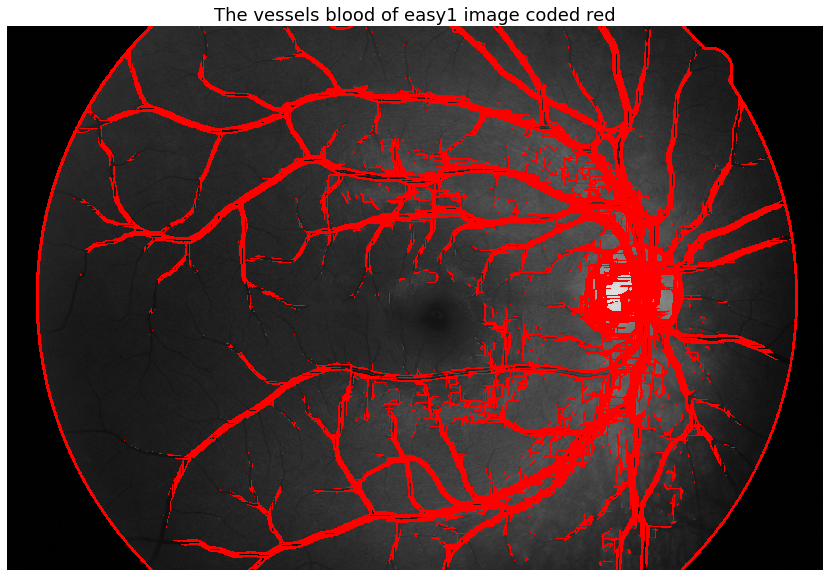

In [942]:
plt.figure(figsize=(15,10))
plt.imshow(I_easy_vessels2,cmap='gray')
plt.axis('off')
plt.title('The vessels blood of easy1 image coded red')

I_gt_easy = np.asarray(imageio.imread('easy1_gt.tif'))
I_gt_easy=np.where(I_gt_easy==255,True,False)
TPR,TNR,FPR,FNR=seg_metrics(I_easy_vessels,I_gt_easy)

print("TPR of easy1 image=",TPR)
print("TNR of easy1 image=",TNR)
print("FPR of easy1 image=",FPR)
print("FNR of easy1 image=",FNR)

#### Medium1 image

TPR of easy1 image= 0.605649679573276
TNR of easy1 image= 0.9241158486155667
FPR of easy1 image= 0.07588415138443323
FNR of easy1 image= 0.39435032042672397


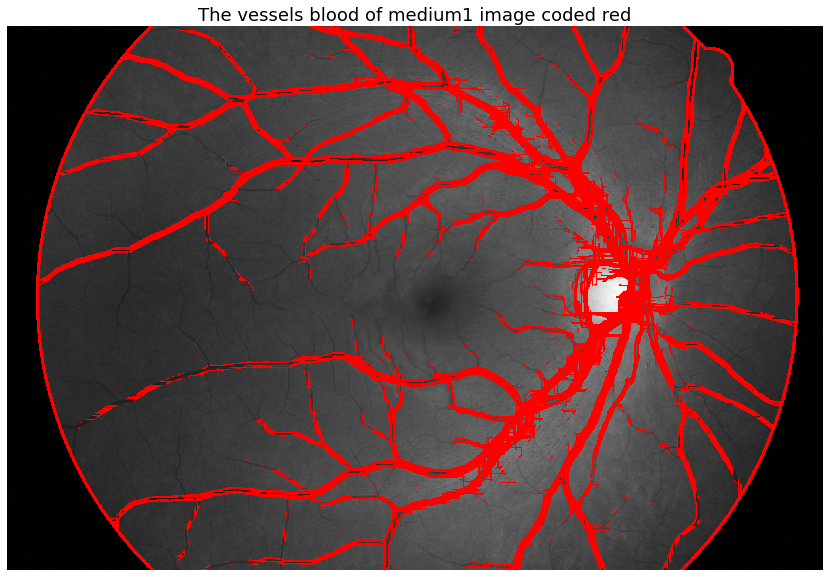

In [943]:
plt.figure(figsize=(15,10))
plt.imshow(I_medium_vessels2,cmap='gray')
plt.axis('off')
plt.title('The vessels blood of medium1 image coded red')

I_gt_meduim = np.asarray(imageio.imread('medium1_gt.tif'))
I_gt_meduim=np.where(I_gt_meduim==255,True,False)
TPR,TNR,FPR,FNR = seg_metrics(I_medium_vessels,I_gt_meduim)

print("TPR of easy1 image=",TPR)
print("TNR of easy1 image=",TNR)
print("FPR of easy1 image=",FPR)
print("FNR of easy1 image=",FNR)

#### Hard1 image

TPR of easy1 image= 0.5129779124585686
TNR of easy1 image= 0.9153489228644122
FPR of easy1 image= 0.08465107713558781
FNR of easy1 image= 0.4870220875414314


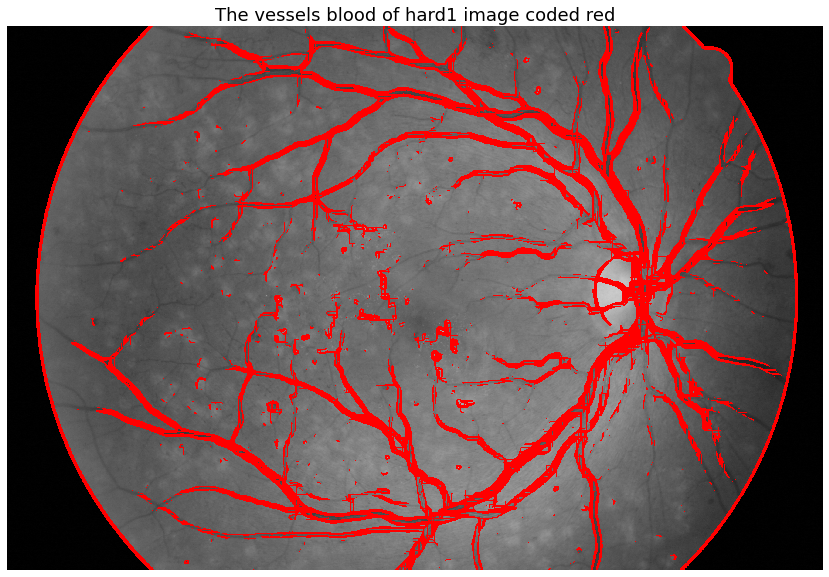

In [944]:
plt.figure(figsize=(15,10))
plt.imshow(I_hard_vessels2,cmap='gray')
plt.axis('off')
plt.title('The vessels blood of hard1 image coded red')

I_gt_hard = np.asarray(imageio.imread('hard1_gt.tif'))
I_gt_hard=np.where(I_gt_hard==255,True,False)
TPR,TNR,FPR,FNR = seg_metrics(I_hard_vessels,I_gt_hard)

print("TPR of easy1 image=",TPR)
print("TNR of easy1 image=",TNR)
print("FPR of easy1 image=",FPR)
print("FNR of easy1 image=",FNR)

### (d-iii) Summary of vessel segmentation performance:

The vessel_segmentation function is used on three different images, easy1, medium1 and hard1. Totally, the performance of this algorithm is good and the percentage of accuracy depends on the characteristics of an image. This method considers the blood vessels as an image edge and tries to find these edges in an image. For this purpose, finding a unique solution for this segmentation is difficult because the size and shape of vessels are varied, the images have different contrast and there is uneven illumination in these images that has a serious effect on the edge detection. This method has a good performance in images that has high contrast because in these images, distinguishing between the blood vessels and background is easier than in low contrast images. Also, this method can handle noisy images by using the averaging filter for smoothing an image. The weakness of this method is for images that have uneven illumination so distinguishing the edges' pixels become difficult. The other weakness is this method cannot distinguish between the blood vessels in the eye and the border of an eye with the image background and the border of the optical disk with the eye background. All of these pixels have sudden changes in their intensities so they are considered edge pixels. The proposed method has good TNR and FPR. For all of the above images, the TNR is higher than 0.9 which is near the desired value of 1 and the FPR is less than 0.1. In the easy image, the blood vessels are segmented with more details but in the medium image, the main branches of blood vessels are detected and this segmentation is less noisy. In the hard image, the image is bright so the probability of error in finding blood vessels is high by using this method. Thus, in some regions, the detection has not been done correctly.